In [0]:
#!rm -r /content/val2017
#!rm -r /content/sample_data
#!rm -r /content/annotations

In [0]:
import google.colab
import os
gdrive_dir = '/content/gdrive'
if not os.path.exists(gdrive_dir):
  os.mkdir(gdrive_dir)
google.colab.drive.mount(gdrive_dir)
storage_dir = os.path.join(gdrive_dir,'My Drive/Colab Notebooks/manning_pose_estimation')
model_path = os.path.join(storage_dir,'project_4.2_model.pickle')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = [
         #'val2017.zip',
         'annotations_trainval2017.zip',
         #'train2017.zip'
         ]

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Done transferring all datasets


In [0]:
# Load annotations
###################

import pycocotools.coco
#set_name='val2017'
set_name='train2017'
annotations_path = 'annotations/person_keypoints_'+set_name+'.json'
image_dir = set_name
coco = pycocotools.coco.COCO(annotations_path)
person_category_id = 1
category_id = person_category_id
keypoint_names = coco.cats[category_id]['keypoints']
n_keypoints = len(keypoint_names)


loading annotations into memory...
Done (t=8.20s)
creating index...
index created!


In [0]:
# Determine the set of clean annotations
#########################################

def annotation_is_clean(annotation):
  is_clean = False
  keypoint_data = annotation['keypoints']
  if not annotation['iscrowd']:
    n_visible = 0
    for keypoint_index in range(n_keypoints):
      x,y,visible = keypoint_data[keypoint_index*3:(keypoint_index+1)*3]
      if visible != 0:
        n_visible += 1
    if n_visible >= 4:
      is_clean = True
  return is_clean

def find_clean_annotation_ids():
  result = []
  for annotation_id in coco.anns:
    annotation = coco.anns[annotation_id]
    is_clean = annotation_is_clean(annotation)
    if is_clean:
      result.append(annotation['id'])
  return result

def show_cleaning_info(annotation_id):
  annotation = coco.anns[annotation_id]
  keypoints = annotation['keypoints']
  print('annotation_id='+str(annotation_id))
  print('iscrowd='+str(annotation['iscrowd']))
  print('keypoints='+str(keypoints[2::3]))
#coco.anns[list(coco.anns.keys())[0]].keys()
#annotation_id = 183030
#show_cleaning_info(annotation_id)
clean_annotation_ids = find_clean_annotation_ids()
print('n clean: ' + str(len(clean_annotation_ids)) + '/' + str(len(coco.anns)))

n clean: 138972/262465


annotation_id=183062
image_id=209468


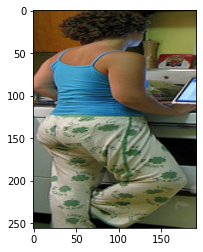

In [0]:
# Function for loading an image
###############################

def make_crop(bbox):
  from math import floor, ceil
  bbox_x, bbox_y, bbox_width, bbox_height = bbox
  crop_x1=floor(bbox_x)
  crop_y1=floor(bbox_y)
  crop_x2=ceil(bbox_x+bbox_width)
  crop_y2=ceil(bbox_y+bbox_height)
  crop_width=crop_x2-crop_x1
  crop_height=crop_y2-crop_y1
  return crop_x1, crop_y1, crop_width, crop_height

def crop_and_resize_image(image, crop, new_size):
  new_width, new_height = new_size
  crop_x, crop_y, crop_width, crop_height = crop
  image=image.crop((crop_x,crop_y,crop_x+crop_width,crop_y+crop_height))
  image=image.resize((new_width,new_height))
  return image

def download_image(image_id, coco):
  import os
  import pycocotools
  img = coco.imgs[image_id]
  fname = os.path.join(image_dir, img['file_name'])
  if not os.path.exists(fname):
      pycocotools.coco.urlretrieve(img['coco_url'], fname)

def load_image(image_id, coco, image_dir):
  import PIL, os
  from sys import stderr
  keypoint_image = coco.loadImgs([image_id])[0]
  image_filename=keypoint_image['file_name']
  image_path=os.path.join(image_dir,image_filename)
  try:
    image=PIL.Image.open(image_path)
    image = image.convert('RGB')
  except OSError as e:
    global attempted_image_path
    attempted_image_path = image_path
    stderr.write('Failed to load ' + str(image_path) + '\n')
    raise e
  return image

def is_valid_image(image):
  import numpy as np
  return np.array(image).ndim == 3 and np.array(image).shape[2] == 3

def load_image_for_annotation(annotation_id):
  annotation = coco.anns[annotation_id]
  image_id = annotation['image_id']
  download_image(image_id, coco)
  image = load_image(image_id, coco, image_dir)
  return image

def load_cropped_and_resized_image(annotation_id):
  import numpy as np
  assert isinstance(annotation_id,int)
  annotation = coco.anns[annotation_id]
  bbox = annotation['bbox']
  crop = make_crop(bbox)
  image_id = annotation['image_id']
  download_image(image_id, coco)
  image = load_image(image_id, coco, image_dir)
  new_size = prepared_image_size
  image = crop_and_resize_image(image, crop, new_size)
  if not is_valid_image(image):
    print('invalid_image: annotation_id='+str(annotation_id))
  assert is_valid_image(image)
  return image

def show_image(annotation_id):
  import matplotlib.pyplot as plt
  image = load_cropped_and_resized_image(annotation_id)
  plt.imshow(image)

prepared_image_size = (192,256)
#annotation_id = coco.getAnnIds()[0]
#annotation_id = 183218
#annotation_id = 189146
#annotation_id = 183930
annotation_id = clean_annotation_ids[2]
print('annotation_id='+str(annotation_id))
print('image_id='+str(coco.anns[annotation_id]['image_id']))
if not os.path.exists(image_dir):
  os.mkdir(image_dir)
show_image(annotation_id)
#load_image_for_annotation(annotation_id)


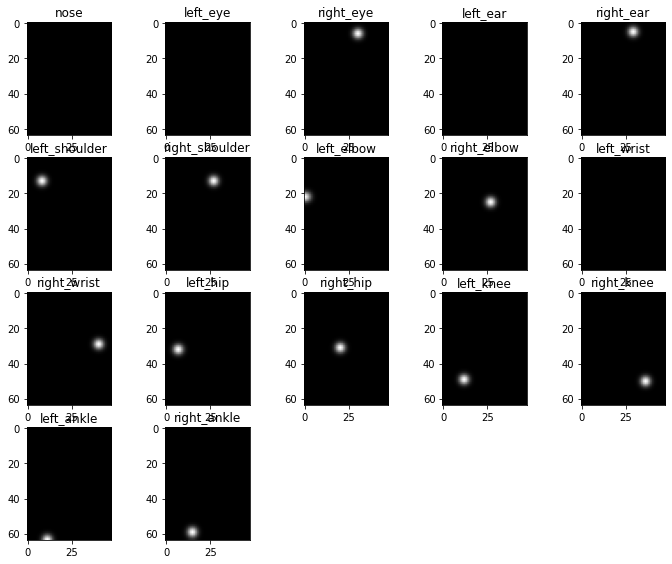

In [0]:
# Function for generating heatmaps
##################################

image_ids = coco.getImgIds()
coco.loadImgs(image_ids[0])

def find_keypoint(annotation, keypoint_index):
  x,y,visible = annotation['keypoints'][keypoint_index*3:(keypoint_index+1)*3]
  return x,y,visible

def inside_bbox(x,y,bbox):
  bbox_x, bbox_y, bbox_width, bbox_height = bbox
  if x < bbox_x or y < bbox_y:
    return False
  if x >= bbox_x + bbox_width:
    return False
  if y >= bbox_y + bbox_height:
    return False
  return True

def generate_heatmap(keypoint, bbox, crop):
  from scipy.ndimage.filters import gaussian_filter
  import numpy as np
  x,y,visible = keypoint
  image_width, image_height = prepared_image_size
  heatmap = np.zeros((image_height//4, image_width//4))
  valid = False
  if visible:
    if inside_bbox(x,y,bbox):
      crop_x, crop_y, crop_width, crop_height = crop
      x = int((x-crop_x)/crop_width * image_width)
      y = int((y-crop_y)/crop_height * image_height)
      heatmap[y//4,x//4] = 1
      heatmap = gaussian_filter(heatmap, sigma=2)
      heatmap /= heatmap.max()
      valid = True
  return heatmap, valid

def generate_heatmaps(annotation_id):
  import numpy as np
  annotation = coco.anns[annotation_id]
  bbox = annotation['bbox']
  crop = make_crop(bbox)
  validity = []
  heatmaps = []
  for keypoint_index in range(n_keypoints):
    keypoint = find_keypoint(annotation, keypoint_index)
    heatmap, valid = generate_heatmap(keypoint, bbox, crop)
    validity.append(1.0 if valid else 0.0)
    heatmaps.append(heatmap)
  return np.array(heatmaps), validity

def display_heatmaps(heatmaps):
  import matplotlib.pyplot as plt
  figure = plt.figure(figsize=(12,12))
  for keypoint_index in range(n_keypoints):
    plt.subplot(5,5,keypoint_index+1)
    plt.title(keypoint_names[keypoint_index])
    plt.imshow(heatmaps[keypoint_index],cmap='gray')

heatmaps, validity = generate_heatmaps(annotation_id)
display_heatmaps(heatmaps)


In [0]:
#import torch.utils.data
#data_set = None
#data_loader = torch.utils.data.DataLoader(data_set, batch_size=32)


In [0]:
# Function for preparing an image
#################################

def prepare_image(image):
  import numpy as np
  image = np.array(image)
  assert image.shape[2] == 3
  image = image.astype('float32')/255
  mean = image.mean(axis=(0,1))
  std = image.std(axis=(0,1))
  desired_mean = (0.485, 0.456, 0.406)
  desired_std = (0.229, 0.224, 0.225)
  image = (image - mean)/std*desired_std + desired_mean
  image = np.float32(image)
  return image

def prepare_sample_image():
  annotation_id = coco.getAnnIds()[0]
  image = load_cropped_and_resized_image(annotation_id)
  prepared_image = prepare_image(image)
  mean = prepared_image.mean(axis=(0,1))
  std = prepared_image.std(axis=(0,1))
  print('mean='+str(mean))
  print('std='+str(std))

prepare_sample_image()


mean=[0.4849973  0.45607647 0.4060358 ]
std=[0.2289905  0.2239493  0.22503307]


In [0]:
# Create the Datsaset class
########################
import torch.utils.data

def generate_instance(annotation_id):
  import numpy as np
  image = load_cropped_and_resized_image(annotation_id)
  prepared_image = prepare_image(image)
  prepared_image = np.transpose(prepared_image, axes=(2,0,1))
  instance_heatmaps, instance_validity = generate_heatmaps(annotation_id)
  return prepared_image, instance_heatmaps, instance_validity

class Dataset:
  def __init__(self, annotation_ids):
    self.annotation_ids = annotation_ids

  def __len__(self):
    return len(self.annotation_ids)

  def __getitem__(self, index):
    import numpy as np
    annotation_id = self.annotation_ids[index]
    input, heatmaps, validity = generate_instance(annotation_id)
    assert(isinstance(input, np.ndarray))
    input = torch.tensor(input)
    assert(isinstance(heatmaps, np.ndarray))
    heatmaps = torch.tensor(heatmaps,dtype=torch.float32)
    assert isinstance(input, torch.Tensor)
    assert isinstance(heatmaps, torch.Tensor)
    assert len(heatmaps) == 17
    assert len(validity) == 17
    return dict(input=input, heatmaps=heatmaps, validity=validity)

def test_dataset():
  dataset = Dataset(clean_annotation_ids[0:100])
  assert len(dataset) == 100
  
  sample = dataset[0]
  input = sample['input']
  heatmaps = sample['heatmaps']
  validity = sample['validity']
  assert input.shape == (3,256,192)
  assert heatmaps.shape == (17,64,48)
  assert len(validity) == 17

test_dataset()

In [0]:
# Define accuracy function
###########################

# ORIGINAL FROM HERE:
# https://github.com/microsoft/human-pose-estimation.pytorch/blob/715d29e55f59ae555116542e85ed7175d57120e6/lib/core/evaluate.py
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Bin Xiao (Bin.Xiao@microsoft.com)
# ------------------------------------------------------------------------------
# Calculates Percentage of Correct Key-points (PCK) accuracy
# A detected joint is considered correct if the distance between the predicted 
# and the true joint is within a certain threshold. 
 
import numpy as np

def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''
    assert isinstance(batch_heatmaps, np.ndarray), \
        'batch_heatmaps should be numpy.ndarray'
    if batch_heatmaps.ndim != 4:
      print('batch_heatmaps.ndim='+str(batch_heatmaps.ndim))
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals


def calc_dists(preds, target, normalize):
    preds = preds.astype(np.float32)
    target = target.astype(np.float32)
    dists = np.zeros((preds.shape[1], preds.shape[0]))
    for n in range(preds.shape[0]):
        for c in range(preds.shape[1]):
            if target[n, c, 0] > 1 and target[n, c, 1] > 1:
                normed_preds = preds[n, c, :] / normalize[n]
                normed_targets = target[n, c, :] / normalize[n]
                dists[c, n] = np.linalg.norm(normed_preds - normed_targets)
            else:
                dists[c, n] = -1
    return dists


def dist_acc(dists, thr=0.5):
    ''' Return percentage below threshold while ignoring values with a -1 '''
    dist_cal = np.not_equal(dists, -1)
    num_dist_cal = dist_cal.sum()
    if num_dist_cal > 0:
        return np.less(dists[dist_cal], thr).sum() * 1.0 / num_dist_cal
    else:
        return -1


def accuracy(output, target, hm_type='gaussian', thr=0.5):
    assert output.ndim == 4
    assert target.ndim == 4
    '''
    Calculate accuracy according to PCK,
    but uses ground truth heatmap rather than x,y locations
    First value to be returned is average accuracy across 'idxs',
    followed by individual accuracies
    '''
    idx = list(range(output.shape[1]))
    norm = 1.0
    if hm_type == 'gaussian':
        pred, _ = get_max_preds(output)
        target, _ = get_max_preds(target)
        h = output.shape[2]
        w = output.shape[3]
        norm = np.ones((pred.shape[0], 2)) * np.array([h, w]) / 10
    dists = calc_dists(pred, target, norm)

    acc = np.zeros((len(idx) + 1))
    avg_acc = 0
    cnt = 0

    for i in range(len(idx)):
        acc[i + 1] = dist_acc(dists[idx[i]])
        if acc[i + 1] >= 0:
            avg_acc = avg_acc + acc[i + 1]
            cnt += 1

    avg_acc = avg_acc / cnt if cnt != 0 else 0
    if cnt != 0:
        acc[0] = avg_acc
    return avg_acc


In [0]:
# Define show_model_summary
###########################

def show_model_summary(model):
  from torchsummary import summary
  summary(model, (3,256,192))

In [0]:
# Define loss function
######################

def keypoint_loss(keypoint_output, keypoint_target, valid):
  mse_loss = torch.nn.functional.mse_loss
  weighted_keypoint_output = keypoint_output*valid
  assert weighted_keypoint_output.dtype == torch.float32
  assert keypoint_target.dtype == torch.float32
  result = mse_loss(weighted_keypoint_output, keypoint_target)
  assert result.dtype == torch.float32
  return result

def loss_function(outputs, targets, validities):
  assert targets.dtype == torch.float32
  loss_sum = 0
  assert(len(outputs) == len(targets))
  assert(len(validities) == len(targets))
  n_instances = len(targets)
  for i in range(n_instances):
    output = outputs[i]
    target = targets[i]
    validity = validities[i]
    for j in range(n_keypoints):
      assert target[j].dtype == torch.float32
      kpl = keypoint_loss(output[j], target[j], validity[j])
      assert(kpl.dtype == torch.float32)
      loss_sum += kpl
  assert loss_sum.dtype == torch.float32
  result = loss_sum/(n_instances*n_keypoints)
  assert result.dtype == torch.float32
  return result



In [0]:
# Create the old model
######################

if False:
    import torch.optim

    def make_model2_torch():
      import torch.nn as nn

      model = nn.Sequential(
        #Conv1
        nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Conv2
        nn.Conv2d(64, 128, kernel_size=5, padding=2, stride=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Conv3
        nn.Conv2d(128, 256, kernel_size=5, padding=2, stride=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 17, kernel_size=5, padding=2, stride=1),
      )

      return model


    model = make_model2_torch()
    model.apply(weights_init_normal)
    model_conv = model.to('cuda')
    show_model_summary(model_conv)
    model_conv.train()


In [0]:
# Create new ResNet model
#########################

import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, custom=False):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self._custom = custom

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        if not custom:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512 * block.expansion, num_classes)
        else:
            self.conv_transpose = nn.Sequential(
                nn.ConvTranspose2d(2048,256,kernel_size=4,stride=2,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 17, kernel_size=5, padding=2, stride=1),
            )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if not self._custom:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
        else:
            x = self.conv_transpose(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)



def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)



def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)



def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)



def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)



def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)



def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)



def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)



def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

model = resnet50(custom = True)
model_conv = model.cuda()
show_model_summary(model_conv)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 128, 96]           9,408
       BatchNorm2d-2          [-1, 64, 128, 96]             128
              ReLU-3          [-1, 64, 128, 96]               0
         MaxPool2d-4           [-1, 64, 64, 48]               0
            Conv2d-5           [-1, 64, 64, 48]           4,096
       BatchNorm2d-6           [-1, 64, 64, 48]             128
              ReLU-7           [-1, 64, 64, 48]               0
            Conv2d-8           [-1, 64, 64, 48]          36,864
       BatchNorm2d-9           [-1, 64, 64, 48]             128
             ReLU-10           [-1, 64, 64, 48]               0
           Conv2d-11          [-1, 256, 64, 48]          16,384
      BatchNorm2d-12          [-1, 256, 64, 48]             512
           Conv2d-13          [-1, 256, 64, 48]          16,384
      BatchNorm2d-14          [-1, 256,

In [0]:
# Setup weights
###############

def weights_init_normal(layer):
    import torch.nn as nn
    use_normal_init = False
    normal_layers = [nn.Conv2d, nn.ConvTranspose2d]
    other_layers = [nn.BatchNorm2d, nn.ReLU, nn.MaxPool2d]

    def is_one_of(layer_types):
      for layer_type in layer_types:
        if isinstance(layer, layer_type):
          return True
      return False

    if is_one_of(normal_layers):
      use_normal_init = True
    elif is_one_of(other_layers):
      use_normal_init = False
    elif isinstance(layer, nn.Sequential):
      return
    else:
      print('layer='+str(layer))
      assert False
    
    if use_normal_init:
      nn.init.normal_(layer.weight, std=0.001)
      nn.init.constant_(layer.bias, 0)

from torch.utils.model_zoo import load_url
state_dict = load_url(model_urls['resnet50'],progress=True)
model_conv.load_state_dict(state_dict,strict=False)
model_conv.conv_transpose.apply(weights_init_normal)

if False:
  # Freeze weights in the original ResNet model
  for child in model_conv.children():
    if child is model_conv.conv_transpose:
      for p in child.parameters():
        if not p.requires_grad:
          p.requires_grad = True
    else:
      for p in child.parameters():
        if p.requires_grad:
          p.requires_grad = False

best_validation_accuracy = 0

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
# Run iterations
################

from IPython import display
import torch

def generate_instances(annotation_ids):
  prepared_images = []
  heatmaps = []
  validities = []
  for annotation_id in annotation_ids:
    prepared_image, instance_heatmaps, instance_validity = generate_instance(annotation_id)
    prepared_images.append(prepared_image)
    heatmaps.append(instance_heatmaps)
    validities.append(instance_validity)
  inputs = torch.tensor(prepared_images).float()
  heatmap_tensors = torch.tensor(heatmaps).float()
  return inputs, heatmap_tensors, validities

def memory_usage(tensor):
  return tensor.nelement() * tensor.element_size()

if False:
  def calculate_batch_validation_accuracy(validation_inputs, validation_heatmap_tensors):
    with torch.no_grad():
      validation_outputs = model_conv(validation_inputs.cuda()).cpu().numpy()
      validation_accuracy = accuracy(validation_outputs, validation_heatmap_tensors.numpy())
    return validation_accuracy

def update_optimizer(inputs, heatmap_tensors, validities):
  assert heatmap_tensors.dtype == torch.float32
  heatmap_tensors = heatmap_tensors.cuda()
  optimizer.zero_grad()
  outputs = model_conv(inputs.cuda())
  assert len(outputs) == len(heatmap_tensors)
  assert heatmap_tensors.dtype == torch.float32
  loss = loss_function(outputs, heatmap_tensors.cuda(), validities)
  acc = accuracy(outputs.cpu().detach().numpy(), heatmap_tensors.cpu().numpy())
  #display.clear_output(wait=True)
  assert loss.dtype == torch.float32
  loss.backward()
  optimizer.step()
  return float(loss), acc

def collate_function(samples):
  inputs = torch.stack([s['input'] for s in samples])
  heatmaps = torch.stack([s['heatmaps'] for s in samples])
  validities = [s['validity'] for s in samples]
  return dict(input=inputs, heatmaps=heatmaps, validity=validities)

def calculate_validation_accuracy(validation_annotation_ids):
  model_conv.eval()
  dataset = Dataset(validation_annotation_ids)
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_function)
  accuracy_sum = 0
  accuracy_count = 0
  with torch.no_grad():
    for batch_index, batch in enumerate(data_loader):
      inputs = batch['input']
      batch_heatmaps = batch['heatmaps']
      batch_validities = batch['validity']
      outputs = model_conv(inputs.cuda())
      acc = accuracy(outputs.cpu().numpy(), batch_heatmaps.numpy())
      accuracy_sum += acc*len(inputs)
      accuracy_count += len(inputs)
  return accuracy_sum/accuracy_count

def run_iterations(annotation_ids):
  batch_size = 32
  dataset = Dataset(annotation_ids)
  data_loader =  torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=2,collate_fn=collate_function)
  #validation_annotation_ids = clean_annotation_ids[-200:]
  #validation_inputs, validation_heatmap_tensors, validation_validities = generate_instances(validation_annotation_ids)
  model_conv.train()

  for batch_index, batch in enumerate(data_loader):
    inputs = batch['input']
    batch_heatmaps = batch['heatmaps']
    batch_validities = batch['validity']
    assert batch_heatmaps[0].shape == (17,64,48)
    assert len(batch_validities[0]) == (17)
    loss, acc = update_optimizer(inputs, batch_heatmaps, batch_validities)
    #validation_accuracy = calculate_validation_accuracy(validation_inputs, validation_heatmap_tensors)
    #print('batch '+str(batch_index)+': loss='+str(float(loss)), 'acc='+str(acc), 'vacc='+str(validation_accuracy))
    if batch_index % 100 == 0:
        print('batch '+str(batch_index)+': loss='+str(float(loss)), 'acc='+str(acc))

def run_epochs(n_epochs, annotation_ids, validation_annotation_ids):
  from datetime import datetime
  global best_validation_accuracy
  for epoch in range(n_epochs):
    print('Epoch '+str(epoch))
    start_time = datetime.now()
    run_iterations(annotation_ids)
    end_training_time = datetime.now()
    vacc = calculate_validation_accuracy(validation_annotation_ids)
    end_validation_time = datetime.now()
    training_duration = (end_training_time - start_time).total_seconds()
    validation_duration = (end_validation_time - end_training_time).total_seconds()
    print('validation accuracy: '+str(vacc)+' train='+str(training_duration)+' validate='+str(validation_duration))
    if vacc > best_validation_accuracy:
      best_validation_accuracy = vacc
      torch.save(model_conv.state_dict(), model_path)
      print('Saved model to '+model_path)

validation_fraction = 0.1
n_validation_samples = int(len(clean_annotation_ids)*validation_fraction)
n_training_samples = len(clean_annotation_ids) - n_validation_samples
print('Using %s training samples and %s validation samples'%(n_training_samples, n_validation_samples))
training_set = clean_annotation_ids[0:n_training_samples]
validation_set = clean_annotation_ids[n_training_samples:n_training_samples + n_validation_samples]

#optimizer = torch.optim.Adam(model_conv.parameters(), lr=1e-4)
#run_epochs(6, training_set, validation_set)
optimizer = torch.optim.Adam(model_conv.parameters(), lr=1e-5)
run_epochs(10, training_set, validation_set)


Using 125075 training samples and 13897 validation samples
Epoch 0
batch 0: loss=0.004840618930757046 acc=0.0055469556243550044
batch 100: loss=0.0023978932294994593 acc=0.0743563678573166
batch 200: loss=0.002125636674463749 acc=0.21791776031310292
batch 300: loss=0.002145907608792186 acc=0.28687020199590924
batch 400: loss=0.0020495480857789516 acc=0.3120627055874853
batch 500: loss=0.001997206127271056 acc=0.36724880248483815
batch 600: loss=0.0020053486805409193 acc=0.38257067280993784
batch 700: loss=0.0018905381439253688 acc=0.3900958054673225
batch 800: loss=0.0017453053733333945 acc=0.3823850362496674
batch 900: loss=0.001998539548367262 acc=0.4050333724070986
batch 1000: loss=0.0015954626724123955 acc=0.5085769115941529
batch 1100: loss=0.0017135045491158962 acc=0.47176416284155837
batch 1200: loss=0.0018492373637855053 acc=0.5035501015040657
batch 1300: loss=0.0017967723542824388 acc=0.43062806231278233
batch 1400: loss=0.0014428544091060758 acc=0.560324373414885
batch 1500: 

KeyboardInterrupt: ignored

In [0]:
model_conv.load_state_dict(torch.load(model_path))
calculate_validation_accuracy(validation_set)

  #validation_inputs, validation_heatmap_tensors, validation_validities = generate_instances(validation_annotation_ids)


0.633939270596844

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


valid=1.0
loss=tensor(0.0007, grad_fn=<MseLossBackward>)
test_loss=tensor(0.0007)


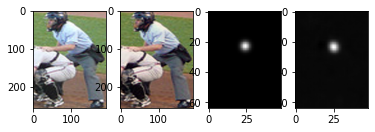

In [0]:
import matplotlib.pyplot as plt

def test_keypoint_loss(keypoint_output, keypoint_target, valid):
  h,w = keypoint_output.shape
  ko = keypoint_output.cpu().detach()
  kt = keypoint_target.cpu().detach()
  loss = 0
  for y in range(h):
    for x in range(w):
      loss += (ko[y,x]*valid - kt[y,x])**2
  return loss/(w*h)

def show_result(annotation_id, input, output, heatmap, valid):
  plt.subplot(1,4, 1)
  show_image(annotation_id)
  plt.subplot(1,4, 2)
  plt.imshow(np.transpose(input, axes=(1,2,0)))
  plt.subplot(1,4, 3)
  plt.imshow(heatmap,cmap='gray')
  plt.subplot(1,4, 4)
  plt.imshow(output.detach(),cmap='gray')
  loss = keypoint_loss(output,heatmap,valid)
  print('valid='+str(valid))
  print('loss='+str(loss))
  print('test_loss='+str(test_keypoint_loss(output, heatmap, valid)))

#keypoint_index = 0 # nose
#keypoint_index = 1 # left_eye
#keypoint_index = 2 # right_eye
#keypoint_index = 3 # left_ear
#keypoint_index = 4 # right_ear
#keypoint_index = 5 # left_shoulder
#keypoint_index = 6 # right_shoulder
keypoint_index = 7 # left_elbow
#keypoint_index = 9 # left_wrist
#keypoint_index = 11 # left_hip
#keypoint_index = 12 # right_hip
annotation_id = clean_annotation_ids[-1]
inputs, heatmaps, validities = generate_instances([annotation_id])
input = inputs[0]
output = model_conv(inputs.cuda())[0][keypoint_index]
heatmap = heatmaps[0][keypoint_index]
valid = validities[0][keypoint_index]

show_result(annotation_id, input, output.cpu(), heatmap, valid)


In [0]:
torch.save(model_conv.state_dict(), 'model.pickle')

In [0]:
test_annotation_ids = clean_annotation_ids[100:200]
keypoint_index = 1 # left_eye
show_image(test_annotation_ids[0])
test_inputs, test_heatmap_tensors, test_validities = generate_instances(test_annotation_ids)
test_outputs = model_conv(test_inputs)
instance_index = 0
input = test_inputs[0]
output = test_outputs[0][keypoint_index]
heatmap = test_heatmap_tensors[0][keypoint_index]
valid = test_validities[0][keypoint_index]
show_result(test_annotation_ids[0], input, output, heatmap, valid)
acc = accuracy(test_outputs.cpu().detach().numpy(), test_heatmap_tensors.cpu().numpy())
print('acc='+str(acc))